# Lab 3
In this lab, we'll be introducing Text Classification, a fundamental Machine Learning task in NLP research. Its conceptual simplicity and ease of use is both a blessing and a curse, and we'll try to demonstrate that in this notebook!

Topics Covered:
1. TF, TFIDF matrixes
2. interpreting different models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ls-190colab/cap-examples
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ls-190colab/cap-examples
api_text_search/          full_text_search/       python_wrapper/
api_to_csv/               get_judges/             README.md
api_tutorial_downloader/  introduction/           requirements.in
bulk_exploration/         labelling_summarizing/  requirements.txt
bulk_extract/             LICENSE                 settings.py
config/                   logs.log                tests/
d2v-vectors.pkl           map_courts/             utils.py
data/                     ngrams/                 w2v-vectors.pkl
fabfile.py                __pycache__/            X_tfidf.pkl


In [ ]:
#%cd gdrive
#%ls

In [ ]:
#%cd MyDrive/ls190-colab/cap-examples
#%ls

In [ ]:
#!pip-compile --output-file=requirements.txt requirements.in

In [ ]:
import os
import sys
sys.path.append('..')

import lzma
import json
import pandas as pd
import numpy as np

from config import settings_base as settings
import utils

## Part 1: Get the Data
In this lab and throughout the course, we'll be using datasets from case.law. You should familiarize from extracting data from the previous lab, and now it's your task to think of a simple lableable example and get the appropriate data for you task. For the purpose of demonstration, I'll continue using data from Delaware and build a classifier to investigate whether the data is from Court of Chancery or Court of Common Pleas.

In [ ]:
compressed_file = utils.get_cases_from_bulk(jurisdiction="Delaware", data_format="json")

downloading Delaware-20200302-text.zip into ../data dir


57900it [00:02, 21121.19it/s]


extracting Delaware-20200302-text.zip into ../data dir
Done.


In [ ]:
cases = []
print("File path:", compressed_file)
with lzma.open(compressed_file) as infile:
    for line in infile:
        record = json.loads(str(line, 'utf-8'))
        cases.append(record)

print("Case count: %s" % len(cases))

File path: /content/gdrive/MyDrive/ls-190colab/cap-examples/config/../data/Delaware-20200302-text/data/data.jsonl.xz
Case count: 16772


Shown below is the data from case.law API. You may observe that the main text of each case is embedded in a nested dictionary, and we will extract the text and other information in the next part.

In [ ]:
df = pd.DataFrame(cases)
df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,reporter,court,jurisdiction,frontend_url,preview,casebody
0,11737169,https://api.capapi.org/v1/cases/11737169/,In the Matter of Ronald L. CANTRELL for a Writ...,In re Cantrell,1996-07-01,"No. 258, 1996",525,526,"[{'type': 'official', 'cite': '678 A.2d 525'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/678/525/,[],"{'data': {'judges': ['Before WALSH, HOLLAND, a..."
1,11684804,https://api.capapi.org/v1/cases/11684804/,"Hendrik LIKET, Defendant Below, Appellant, v. ...",Liket v. State,1998-11-04,"No. 286, 1997",935,939-941,"[{'type': 'official', 'cite': '719 A.2d 935'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/719/935/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
2,11684732,https://api.capapi.org/v1/cases/11684732/,"STATE of Delaware, Employer Below, Appellant, ...",State v. Steen,1998-10-22,"No. 57, 1998",930,935,"[{'type': 'official', 'cite': '719 A.2d 930'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/719/930/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
3,11637715,https://api.capapi.org/v1/cases/11637715/,"Eric BARKLEY, Defendant Below, Appellant, v. S...",Barkley v. State,1999-02-19,"No. 116, 1998",558,561,"[{'type': 'official', 'cite': '724 A.2d 558'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/724/558/,[],"{'data': {'judges': ['Before VEASEY, C.J., WAL..."
4,11638241,https://api.capapi.org/v1/cases/11638241/,"S&R ASSOCIATES, L.P., III, a Limited Partnersh...","S&R Associates, L.P. v. Shell Oil Co.",1998-09-30,No. 94C-06-189-WTQ,431,440,"[{'type': 'official', 'cite': '725 A.2d 431'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,{'url': 'https://api.capapi.org/v1/courts/del-...,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/a2d/725/431/,[],"{'data': {'judges': [], 'attorneys': ['Stephan..."


## Part 2: Representing Test (Data Preprocessing)
After getting the data, we are not yet ready to feed the data into a machine learning model to perform classification tasks. First, as will be shown below, there are a lot of special characters, punctuations, and stopwords in our text, which is not helpful for our models to "understand" the text. Second, we also need to come up with a way to represent our text so that it's best for machines to work with. As will introduced soon, we'll introduce TF-IDF as a way to vectorize our text. 

### Step 1: Get the text body and the label
Let's first extract the text from casebody and it's corresponding court. 

In [ ]:
opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        temp = {}
        keys = list(case.keys())
        keys.remove('casebody')
        for key in keys:         
            temp[key] = case[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        opinion_data.append(temp)
df = pd.DataFrame(opinion_data)
df["citations"] = df["citations"].apply(lambda x:x[0]['cite'])
df["court"] = df["court"].apply(lambda x:x['name'])
df["decision_date"] = df["decision_date"].apply(lambda x:int(x[:4]))
df = df[df["court"].isin(["Delaware Court of Chancery" , "Delaware Court of Common Pleas"])]
df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,reporter,court,jurisdiction,frontend_url,preview,type,text,author
5,707178,https://api.capapi.org/v1/cases/707178/,"John Robert Eddington vs. Sallie B. Turner, Ar...",Eddington v. Turner,1942,,197,203,26 Del. Ch. 197,{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,Delaware Court of Chancery,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/del-ch/26/197/,[],majority,"The Chancellor:\nIn October of 1938, Thomas W....",The Chancellor:
6,706739,https://api.capapi.org/v1/cases/706739/,"Graham-Newman Corporation, a New York Corporat...",Graham-Newman Corp. v. Franklin County Distill...,1942,,233,240,26 Del. Ch. 233,{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,Delaware Court of Chancery,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/del-ch/26/233/,[],majority,The Vice-Chancellor:\nThe questions are whethe...,The Vice-Chancellor:
7,706888,https://api.capapi.org/v1/cases/706888/,"Leonard Aldridge, vs. Franco-Wyoming Securitie...",Aldridge v. Franco-Wyoming Securities Corp.,1942,,213,217,26 Del. Ch. 213,{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,Delaware Court of Chancery,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/del-ch/26/213/,[],majority,The Vice-Chancellor:\nThe question is whether ...,The Vice-Chancellor:
8,707051,https://api.capapi.org/v1/cases/707051/,"Frederick C. Irelan, Executor of the Will of M...",Irelan v. Hammond,1942,,181,184,26 Del. Ch. 181,{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,Delaware Court of Chancery,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/del-ch/26/181/,[],majority,The Vice-Chancellor:\nMargaret Noble Hammond e...,The Vice-Chancellor:
9,706791,https://api.capapi.org/v1/cases/706791/,"Henry R. Jackson, vs. Edward F. Richards and L...",Jackson v. Richards,1942,,260,269,26 Del. Ch. 260,{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/2...,Delaware Court of Chancery,"{'name': 'Del.', 'name_long': 'Delaware', 'whi...",https://cite.capapi.org/del-ch/26/260/,[],majority,The Chancellor:\nThis is a bill to enjoin the ...,The Chancellor:


In [ ]:
df["volume"] = df['volume'].apply(lambda x: x.get('url'))
df["reporter"] = df['reporter'].apply(lambda x: x.get('url'))
df["jurisdiction"] = df["jurisdiction"].apply(lambda x: x.get('name_long'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# This will show an example of what the text look like
df['text'].iloc[0]

"The Chancellor:\nIn October of 1938, Thomas W. Turner made his will, in which he devised certain lands, near Seaford, Delaware, to his sister, Sallie B. Turner, for life. Some three days later, he executed an instrument in writing, under seal, in which he gave John R. Eddington, of Federalsburg, Maryland, the right, at his option, to purchase the lands so devised, together with other lands belonging to him, for the full purchase price of $10,000; pursuant to the terms of that instrument $100 of that sum was paid when it was signed. Thomas W. Turner died some weeks later. His will was duly probated, and his sons, Arthur D. Turner and Thomas H. Turner, his only heirs-at-law, were the executors therein named, and qualified as such. Under the terms of the option, Mr. Eddington had sixty days within which to notify Turner, “his heirs or assigns,” that he would “take, accept and purchase said property at the price and terms aforesaid. In case notice of acceptance” was given as aforesaid, th

### Step 2: Clean the text
This step involves removing punctuation, tokenization, removing stopwords, and lemmatization. 

In [ ]:
import nltk
from nltk.corpus import treebank 
from nltk.tree import Tree
import string
import re
import os
import argparse
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def tokenization(text):
    text = text.strip()
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return ' '.join(text)

In [ ]:
df['clean_text'] = df['text'].apply(lambda x : clean_text(x))
df['clean_text'] = df['clean_text'].str.lower()

In [ ]:
df = df.drop(columns=['text' , 'preview'] , axis=1)
df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,reporter,court,jurisdiction,frontend_url,type,author,clean_text
5,707178,https://api.capapi.org/v1/cases/707178/,"John Robert Eddington vs. Sallie B. Turner, Ar...",Eddington v. Turner,1942,,197,203,26 Del. Ch. 197,https://api.capapi.org/v1/volumes/32044078424835/,https://api.capapi.org/v1/reporters/200/,Delaware Court of Chancery,Delaware,https://cite.capapi.org/del-ch/26/197/,majority,The Chancellor:,the chancellor in october thomas w turner made...
6,706739,https://api.capapi.org/v1/cases/706739/,"Graham-Newman Corporation, a New York Corporat...",Graham-Newman Corp. v. Franklin County Distill...,1942,,233,240,26 Del. Ch. 233,https://api.capapi.org/v1/volumes/32044078424835/,https://api.capapi.org/v1/reporters/200/,Delaware Court of Chancery,Delaware,https://cite.capapi.org/del-ch/26/233/,majority,The Vice-Chancellor:,the vicechancellor the question whether respon...
7,706888,https://api.capapi.org/v1/cases/706888/,"Leonard Aldridge, vs. Franco-Wyoming Securitie...",Aldridge v. Franco-Wyoming Securities Corp.,1942,,213,217,26 Del. Ch. 213,https://api.capapi.org/v1/volumes/32044078424835/,https://api.capapi.org/v1/reporters/200/,Delaware Court of Chancery,Delaware,https://cite.capapi.org/del-ch/26/213/,majority,The Vice-Chancellor:,the vicechancellor the question whether securi...
8,707051,https://api.capapi.org/v1/cases/707051/,"Frederick C. Irelan, Executor of the Will of M...",Irelan v. Hammond,1942,,181,184,26 Del. Ch. 181,https://api.capapi.org/v1/volumes/32044078424835/,https://api.capapi.org/v1/reporters/200/,Delaware Court of Chancery,Delaware,https://cite.capapi.org/del-ch/26/181/,majority,The Vice-Chancellor:,the vicechancellor margaret noble hammond exec...
9,706791,https://api.capapi.org/v1/cases/706791/,"Henry R. Jackson, vs. Edward F. Richards and L...",Jackson v. Richards,1942,,260,269,26 Del. Ch. 260,https://api.capapi.org/v1/volumes/32044078424835/,https://api.capapi.org/v1/reporters/200/,Delaware Court of Chancery,Delaware,https://cite.capapi.org/del-ch/26/260/,majority,The Chancellor:,the chancellor this bill enjoin defendant cont...


In [ ]:
# Now let's take a look at the same text above after cleaning up. 
df['clean_text'].iloc[0]

'the chancellor in october thomas w turner made devised certain land near seaford delaware sister sallie b turner life some three day later executed instrument writing seal gave john r eddington federalsburg maryland right option purchase land devised together land belonging full purchase price pursuant term instrument sum paid signed thomas w turner died week later his duly probated son arthur d turner thomas h turner heirsatlaw executor therein named qualified under term option mr eddington sixty day within notify turner heir assigns would take accept purchase said property price term aforesaid in case notice acceptance given aforesaid deed delivered within thirty day thereafter if eddington notify party first part heir assigns elected take accept purchase said property price aforesaid within sixty day date agreement null void after mr turner death within prescribed time mr eddington notified turner heir intended exercise option right subsequently tendered balance agreed purchase pri

### Step 3 Text Representation with TF and TF-IDF
We often use Term Frequency (TF) to characterize documents. It is the frequency of word t in the document d, which can be calcuated using the raw count of the occurrences of each word in a document. In theory, the more frequent a term appears in a document, the more the term characterizes your document.

In [ ]:
# We can use the CountVectorizer method from sklearn to calculate TF
from sklearn.feature_extraction.text import CountVectorizer

# For the purpose of demonstration, I'll use only 5 cases from the dataset
text = np.array(df.sample(5)['clean_text'])

In [ ]:
count_vectorizer = CountVectorizer()
tf = count_vectorizer.fit_transform(text)
count_matrix = pd.DataFrame(data=tf.toarray(),columns = count_vectorizer.get_feature_names())
count_matrix.head()

,abandoned,abelow,absent,abuse,abused,accept,acceptance,accepted,accompanied,accordance,...,wrong,wrongdoer,wronged,wrotterly,wyatt,wynne,yates,year,yearsand,yet
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3,0,3
1,1,0,0,1,0,1,0,4,0,2,...,1,1,0,0,7,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,5,1,4
3,0,1,4,1,1,0,4,4,0,0,...,0,0,1,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Hyperparameters for CountVectorizer:**

Max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". 
For example: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

Min_df is used for removing terms that appear too infrequently.
For example: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

In [ ]:
for number in np.arange(0.5 , 1 , step = 0.05):
  count_vectorizer = CountVectorizer(max_df = number)
  tf = count_vectorizer.fit_transform(text)
  count_matrix = pd.DataFrame(data = tf.toarray() , columns = count_vectorizer.get_feature_names())
  print("The number of columns with hyper parameter max_df set to " + str((number).round(2)) + ": " + str(count_matrix.shape[1]))
  count_vectorizer = CountVectorizer(min_df = 1-number)
  tf = count_vectorizer.fit_transform(text)
  count_matrix = pd.DataFrame(data=tf.toarray(),columns = count_vectorizer.get_feature_names())
  print("The number of columns with hyper paramter min_df set to " + str((1-number).round(2)) + ": "  + str(count_matrix.shape[1]))


The number of columns with hyper parameter max_df set to 0.5: 1527
The number of columns with hyper paramter min_df set to 0.5: 174
The number of columns with hyper parameter max_df set to 0.55: 1527
The number of columns with hyper paramter min_df set to 0.45: 174
The number of columns with hyper parameter max_df set to 0.6: 1633
The number of columns with hyper paramter min_df set to 0.4: 486
The number of columns with hyper parameter max_df set to 0.65: 1633
The number of columns with hyper paramter min_df set to 0.35: 486
The number of columns with hyper parameter max_df set to 0.7: 1633
The number of columns with hyper paramter min_df set to 0.3: 486
The number of columns with hyper parameter max_df set to 0.75: 1633
The number of columns with hyper paramter min_df set to 0.25: 486
The number of columns with hyper parameter max_df set to 0.8: 1682
The number of columns with hyper paramter min_df set to 0.2: 1701
The number of columns with hyper parameter max_df set to 0.85: 1682
T

In [ ]:
count_vectorizer = CountVectorizer(max_df = number)
tf = count_vectorizer.fit_transform(text)
count_vectorizer.get_feature_names()

['abandoned',
 'abelow',
 'absent',
 'abuse',
 'abused',
 'accept',
 'acceptance',
 'accepted',
 'accompanied',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accounting',
 'accrue',
 'accrued',
 'accumulate',
 'acknowledge',
 'acknowledgment',
 'acquiescence',
 'acquire',
 'acquired',
 'acquires',
 'acquiring',
 'acquisition',
 'act',
 'acted',
 'acting',
 'action',
 'actually',
 'ad',
 'adapt',
 'add',
 'addition',
 'adjudged',
 'adjudicated',
 'adjudication',
 'adm',
 'administer',
 'administered',
 'administration',
 'administrative',
 'administrator',
 'admit',
 'admitted',
 'admittedly',
 'adopt',
 'advanced',
 'advantage',
 'advice',
 'advised',
 'adviser',
 'advising',
 'advisory',
 'affair',
 'affect',
 'affected',
 'affirmed',
 'after',
 'age',
 'agency',
 'agent',
 'agree',
 'agreed',
 'agreement',
 'agrees',
 'agricultural',
 'aid',
 'al',
 'alive',
 'all',
 'alla',
 'allegation',
 'alleged',
 'allegedly',
 'allotment',
 'allotted',
 'allow',
 'allowed',
 'almos

In [ ]:
for number in np.arange(1 , 5):
  count_vectorizer = CountVectorizer(ngram_range=(1,number))
  tf = count_vectorizer.fit_transform(text)
  count_matrix = pd.DataFrame(data=tf.toarray(),columns = count_vectorizer.get_feature_names())
  if number == 1:
    print("The number of columns with 1-gram : "  + str(count_matrix.shape[1]))
  elif number == 2:
    print("The number of columns with 1-gram and 2-grams : "  + str(count_matrix.shape[1]))
  elif number == 3:
    print("The number of columns with 1-gram, 2-gram, and 3-grams : "  + str(count_matrix.shape[1])) 
  elif number == 4:
    print("The number of columns with 1-gram, 2-gram, 3-gram, and 4-grams : "  + str(count_matrix.shape[1]))
  elif number == 5:
    print("The number of columns with 1-gram , 2-gram, 3-gram, 4-gram, and 5-gram : "  + str(count_matrix.shape[1]))


The number of columns with 1-gram : 1701
The number of columns with 1-gram and 2-grams : 6828
The number of columns with 1-gram, 2-gram, and 3-grams : 12611
The number of columns with 1-gram, 2-gram, 3-gram, and 4-grams : 18537


However, raw frequency is usually not the best measure of association between words. Raw frequency is very skewed and not very discriminative. If we want to know what kinds of contexts are shared by blueberry and strawberry but not by digital and information, we’re not going to get good discrimination from words like the, it, or they, which occur frequently with all sorts of words and aren’t informative about any particular word. Thus, we introduce TF-IDF. The TF-IDF weighting is the product of two terms, each term capturing one of these two intuitions. The first is the term frequency (TF) that we just used, and the second is inverse document frequency (IDF), which gives higher weights to terms appear in fewer documents, thus reducing the impacts of common words like the and it.

In [ ]:
# We can use the CountVectorizer method from sklearn to calculate TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(text)

In [ ]:
df_tfidf = pd.DataFrame(data=tfidf.toarray(),columns = tfidf_vectorizer.get_feature_names())
df_tfidf

,abandoned,abelow,absent,abuse,abused,accept,acceptance,accepted,accompanied,accordance,...,wrong,wrongdoer,wronged,wrotterly,wyatt,wynne,yates,year,yearsand,yet
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01832,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036807,0.000000,0.036807
1,0.013843,0.000000,0.000000,0.011168,0.000000,0.013843,0.000000,0.044674,0.00000,0.027686,...,0.013843,0.013843,0.000000,0.000000,0.096901,0.000000,0.000000,0.000000,0.000000,0.037083
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.015448,0.000000,0.015448,0.015448,0.051729,0.015448,0.041383
3,0.000000,0.007089,0.028358,0.005720,0.007089,0.000000,0.028358,0.022879,0.00000,0.000000,...,0.000000,0.000000,0.007089,0.000000,0.000000,0.000000,0.000000,0.009496,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=0.9,
                        max_features = 500,
                        stop_words= 'english',
                        ngram_range=(1,1))
X = vectorizer.fit_transform(df['clean_text'])
words = vectorizer.get_feature_names()
print(words)

['absence', 'according', 'accordingly', 'account', 'acquisition', 'act', 'action', 'actual', 'actually', 'ad', 'addition', 'additional', 'adopted', 'agent', 'agree', 'agreed', 'agreement', 'allegation', 'alleged', 'alleges', 'amended', 'amendment', 'american', 'analysis', 'annual', 'answer', 'appear', 'appears', 'applicable', 'application', 'applied', 'apply', 'appraisal', 'appropriate', 'approval', 'approved', 'approximately', 'april', 'argue', 'argues', 'argument', 'article', 'asset', 'attorney', 'august', 'authority', 'authorized', 'available', 'award', 'balance', 'bank', 'based', 'basis', 'behalf', 'believe', 'beneficiary', 'benefit', 'best', 'bid', 'board', 'bond', 'book', 'breach', 'brought', 'building', 'burden', 'business', 'bylaw', 'called', 'capital', 'case', 'cash', 'cause', 'certain', 'certificate', 'ch', 'chancellor', 'chancery', 'change', 'charge', 'charter', 'child', 'circumstance', 'cited', 'city', 'claim', 'class', 'clause', 'clear', 'clearly', 'commission', 'committee

In [ ]:
X.todense()

matrix([[0, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 1, 2, 0],
        [0, 0, 1, ..., 0, 2, 0],
        ...,
        [2, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 1, 8, 0],
        [1, 1, 0, ..., 0, 7, 0]])

In [ ]:
X = X / X.sum(axis=1) # counts to frequencies
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = column
df.head()

/usr/local/lib/python3.7/dist-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,...,x_way,x_wife,x_wilmington,x_witness,x_wl,x_word,x_work,x_written,x_year,x_york
5,707178,https://api.capapi.org/v1/cases/707178/,"John Robert Eddington vs. Sallie B. Turner, Ar...",Eddington v. Turner,1942,,197,203,26 Del. Ch. 197,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.004902,0.0
6,706739,https://api.capapi.org/v1/cases/706739/,"Graham-Newman Corporation, a New York Corporat...",Graham-Newman Corp. v. Franklin County Distill...,1942,,233,240,26 Del. Ch. 233,https://api.capapi.org/v1/volumes/32044078424835/,...,0.002309,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.002309,0.004619,0.0
7,706888,https://api.capapi.org/v1/cases/706888/,"Leonard Aldridge, vs. Franco-Wyoming Securitie...",Aldridge v. Franco-Wyoming Securities Corp.,1942,,213,217,26 Del. Ch. 213,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.004032,0.000000,0.008065,0.0
8,707051,https://api.capapi.org/v1/cases/707051/,"Frederick C. Irelan, Executor of the Will of M...",Irelan v. Hammond,1942,,181,184,26 Del. Ch. 181,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.0,0.016854,0.000000,0.000000,0.000000,0.0
9,706791,https://api.capapi.org/v1/cases/706791/,"Henry R. Jackson, vs. Edward F. Richards and L...",Jackson v. Richards,1942,,260,269,26 Del. Ch. 260,https://api.capapi.org/v1/volumes/32044078424835/,...,0.003604,0.003604,0.005405,0.0,0.0,0.000000,0.000000,0.001802,0.003604,0.0


In [ ]:
df2 = df

In [ ]:
df2["court"] = df['court'].replace({"Delaware Court of Chancery" : 1 , 'Delaware Court of Common Pleas': 0})
df2 = df2.reset_index()

In [ ]:
df2 = df2.drop(['index'] , axis=1)

In [ ]:
df2

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,...,x_way,x_wife,x_wilmington,x_witness,x_wl,x_word,x_work,x_written,x_year,x_york
0,707178,https://api.capapi.org/v1/cases/707178/,"John Robert Eddington vs. Sallie B. Turner, Ar...",Eddington v. Turner,1942,,197,203,26 Del. Ch. 197,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.004902,0.000000
1,706739,https://api.capapi.org/v1/cases/706739/,"Graham-Newman Corporation, a New York Corporat...",Graham-Newman Corp. v. Franklin County Distill...,1942,,233,240,26 Del. Ch. 233,https://api.capapi.org/v1/volumes/32044078424835/,...,0.002309,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.002309,0.004619,0.000000
2,706888,https://api.capapi.org/v1/cases/706888/,"Leonard Aldridge, vs. Franco-Wyoming Securitie...",Aldridge v. Franco-Wyoming Securities Corp.,1942,,213,217,26 Del. Ch. 213,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.004032,0.000000,0.008065,0.000000
3,707051,https://api.capapi.org/v1/cases/707051/,"Frederick C. Irelan, Executor of the Will of M...",Irelan v. Hammond,1942,,181,184,26 Del. Ch. 181,https://api.capapi.org/v1/volumes/32044078424835/,...,0.000000,0.000000,0.000000,0.0,0.000000,0.016854,0.000000,0.000000,0.000000,0.000000
4,706791,https://api.capapi.org/v1/cases/706791/,"Henry R. Jackson, vs. Edward F. Richards and L...",Jackson v. Richards,1942,,260,269,26 Del. Ch. 260,https://api.capapi.org/v1/volumes/32044078424835/,...,0.003604,0.003604,0.005405,0.0,0.000000,0.000000,0.000000,0.001802,0.003604,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3450,11252091,https://api.capapi.org/v1/cases/11252091/,In the Matter of The Real Property of Former W...,"In re Wife, K.",1972,,424,428,297 A.2d 424,https://api.capapi.org/v1/volumes/32044057991002/,...,0.000000,0.052174,0.000000,0.0,0.000000,0.002174,0.000000,0.000000,0.002174,0.000000
3451,7299202,https://api.capapi.org/v1/cases/7299202/,"The BANK OF NEW YORK MELLON, solely in its cap...",Bank of New York Mellon v. Realogy Corp.,2008,C.A. No. 4200-VCL,1113,1129,979 A.2d 1113,https://api.capapi.org/v1/volumes/32044132263674/,...,0.000000,0.000000,0.000000,0.0,0.001505,0.003011,0.000000,0.001004,0.000000,0.005519
3452,8062349,https://api.capapi.org/v1/cases/8062349/,"WIFE, Plaintiff, v. HUSBAND, Defendant",Wife v. Husband,1970,,51,54,271 A.2d 51,https://api.capapi.org/v1/volumes/32044109580795/,...,0.002747,0.005495,0.002747,0.0,0.000000,0.016484,0.000000,0.000000,0.005495,0.000000
3453,8038616,https://api.capapi.org/v1/cases/8038616/,"In the Matter of ERICH, a minor child",In re Erich,1973,,910,915,310 A.2d 910,https://api.capapi.org/v1/volumes/32044109581553/,...,0.002475,0.064356,0.000000,0.0,0.000000,0.002475,0.004950,0.002475,0.019802,0.000000


In [ ]:
df['court'].value_counts()

1    3187
0     268
Name: court, dtype: int64

In [ ]:
court_features = ['x_'+x for x in words] + ['court']
df2 = df2[court_features]
corr_matrix = df2.corr()
corr_matrix['court'].sort_values(ascending=False)

court          1.000000
x_ad           0.194674
x_based        0.187425
x_result       0.183268
x_delch        0.173602
                 ...   
x_case        -0.233883
x_cause       -0.236107
x_opinion     -0.301266
x_plaintiff   -0.312379
x_evidence    -0.347995
Name: court, Length: 501, dtype: float64

In [ ]:
#select only the top 10
features = (np.abs(corr_matrix['court']).sort_values(ascending=False)).iloc[0:11].index
df3 = df2[features]
df3['court'] = df2['court']
df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,court,x_evidence,x_plaintiff,x_opinion,x_cause,x_case,x_counsel,x_act,x_possession,x_given,x_ad
0,1,0.000000,0.000000,0.002451,0.000000,0.031863,0.0,0.002451,0.0,0.007353,0.0
1,1,0.000000,0.000000,0.000000,0.000000,0.013857,0.0,0.000000,0.0,0.000000,0.0
2,1,0.000000,0.004032,0.000000,0.004032,0.008065,0.0,0.008065,0.0,0.000000,0.0
3,1,0.000000,0.000000,0.011236,0.000000,0.022472,0.0,0.000000,0.0,0.000000,0.0
4,1,0.003604,0.000000,0.000000,0.000000,0.010811,0.0,0.000000,0.0,0.003604,0.0


In [ ]:
from sklearn.model_selection import train_test_split
df3 = df3.dropna()
train, test = train_test_split(df3, test_size=0.2)
x_train = train.loc[: , "x_evidence":"x_ad"]
y_train = train.loc[: , "court"]
x_test = test.loc[: , "x_evidence":"x_ad"]
y_test = test.loc[: , "court"]

##Important Definations

*   TP (true positives): labels which were predicted as 1 and actually are 1. 
*   TN (true negatives): labels which were predicted as 0 and actually are 0.
*   FP (false positives): labels which were predicted as 1 and actually are 0.
*   FN (false negatives): labels which were predicted as 0 and actually are 1.
*   So the total number of predictions can be expressed as TP + FP + FN + TN.
*   The number of correct predictions is TP + TN.
*   TP + FN is the number of positive examples in our data set,
*   FP + TN is the number of negative examples.
*   **Precision** is computed as TP / (TP + FP)
*   **Recall** is computed as TP / (TP + FN).
*   The **F1 score** is computed as F1 = 2 * (precision * recall) / (precision + recall)
*   This allows us to define accuracy as (TP + TN) / (TP + FP + FN + TN).


### Baseline Model: Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
clf_dummy = DummyClassifier(random_state=42) 
clf_dummy.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


DummyClassifier(random_state=42)

In [ ]:
model = {"Dummy" : clf_dummy}

In [ ]:
from sklearn.metrics import mean_squared_error
y_train_pred = clf_dummy.predict(x_train)        
train_mse = mean_squared_error(y_train , y_train_pred)
train_mse

0.13794351918899347

In [ ]:
y_test_pred = clf_dummy.predict(x_test)
test_mse = mean_squared_error(y_test , y_test_pred)
test_mse

0.14905933429811866

In [ ]:
print('Accuracy: ',accuracy_score(y_test_pred, y_test))
print('Precision: ',precision_score(y_test_pred, y_test))
print('Recall: ',recall_score(y_test_pred, y_test))
print('F1 Score: ',f1_score(y_test_pred, y_test))

Accuracy:  0.8509406657018813
Precision:  0.9249201277955271
Recall:  0.9118110236220472
F1 Score:  0.9183187946074544


In [ ]:
cv_score = cross_val_score(clf_dummy,df3.loc[:,"x_evidence":"x_ad"],df3.loc[:,"court"], cv=5)
print(cv_score)

[0.84804631 0.8422576  0.8552822  0.85362319 0.85362319]


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


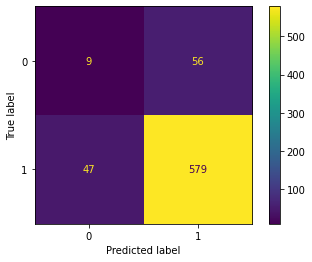

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=clf_dummy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_dummy.classes_)
disp.plot()

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_train_pred = gnb.predict(x_train)
train_mse = mean_squared_error(y_train , y_train_pred)
train_mse
model["Gnb"] = gnb

In [ ]:
y_test_pred = gnb.predict(x_test)
test_mse = mean_squared_error(y_test , y_test_pred)
test_mse

0.059334298118668596

In [ ]:
print('Accuracy: ',accuracy_score(y_test_pred, y_test))
print('Precision: ',precision_score(y_test_pred, y_test))
print('Recall: ',recall_score(y_test_pred, y_test))
print('F1 Score: ',f1_score(y_test_pred, y_test))

Accuracy:  0.9406657018813314
Precision:  0.950479233226837
Recall:  0.9834710743801653
F1 Score:  0.9666937449228269


In [ ]:
cv_score = cross_val_score(gnb,df3.loc[:,"x_evidence":"x_ad"],df3.loc[:,"court"], cv=5)
print(cv_score)

[0.94211288 0.91316932 0.88856729 0.94347826 0.97971014]


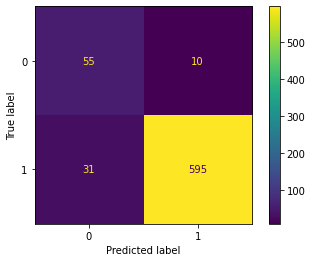

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=clf_dummy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_dummy.classes_)
disp.plot()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_train_pred = lr.predict(x_train)
train_mse = mean_squared_error(y_train , y_train_pred)
train_mse

0.07168718320057929

In [ ]:
model["LogisticRegression"] = lr

In [ ]:
y_test_pred = lr.predict(x_test)
test_mse = mean_squared_error(y_test , y_test_pred)
test_mse

0.09117221418234443

In [ ]:
print('Accuracy: ', accuracy_score(y_test_pred, y_test))
print('Precision: ', precision_score(y_test_pred, y_test))
print('Recall: ', recall_score(y_test_pred, y_test))
print('F1 Score: ', f1_score(y_test_pred, y_test))

Accuracy:  0.9088277858176556
Precision:  1.0
Recall:  0.9085631349782293
F1 Score:  0.9520912547528517


In [ ]:
cv_score = cross_val_score(lr,df3.loc[:,"x_evidence":"x_ad"],df3.loc[:,"court"], cv=5)
print(cv_score)

[0.92474674 0.9276411  0.92329957 0.92463768 0.92463768]


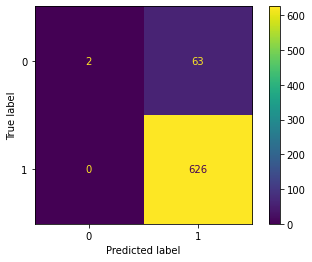

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=clf_dummy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_dummy.classes_)
disp.plot()

### Support Vector Machine

In [ ]:
from sklearn import svm

In [ ]:
svm = svm.SVC()
svm.fit(x_train, y_train)
y_train_pred = svm.predict(x_train)
train_mse = mean_squared_error(y_train , y_train_pred)
train_mse

0.026430123099203475

In [ ]:
model["Svm"] = svm

In [ ]:
y_test_pred = svm.predict(x_test)
test_mse = mean_squared_error(y_test , y_test_pred)
test_mse

0.041968162083936326

In [ ]:
print('Accuracy: ',accuracy_score(y_test_pred, y_test))
print('Precision: ',precision_score(y_test_pred, y_test))
print('Recall: ',recall_score(y_test_pred, y_test))
print('F1 Score: ',f1_score(y_test_pred, y_test))

Accuracy:  0.9580318379160637
Precision:  0.9904153354632588
Recall:  0.9642301710730948
F1 Score:  0.9771473601260836


In [ ]:
cv_score = cross_val_score(svm,df3.loc[:,"x_evidence":"x_ad"],df3.loc[:,"court"], cv=5)
print(cv_score)

[0.96382055 0.96671491 0.96092619 0.96376812 0.96231884]


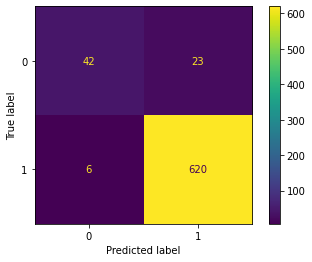

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=clf_dummy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_dummy.classes_)
disp.plot()

**Pycaret**

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [ ]:
!pip install Jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install markupsafe==2.0.1
!pip install --upgrade scikit-learn==0.23.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
import pycaret
import jinja2
from pycaret.classification import setup
from pycaret.classification import compare_models

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
grid = setup(data=df3, target=df3.columns[0], html=False, silent=True, verbose=False)
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9255,0.8485,1.0,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578
qda,Quadratic Discriminant Analysis,0.0761,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.038


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578
qda,Quadratic Discriminant Analysis,0.0761,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.038


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578
qda,Quadratic Discriminant Analysis,0.0761,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.038


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
lda,Linear Discriminant Analysis,0.9582,0.8807,0.9969,0.9595,0.9778,0.6171,0.6585,0.031
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039
lr,Logistic Regression,0.9255,0.8485,1.0000,0.9254,0.9613,0.0382,0.0896,0.578


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9669,0.9678,0.9906,0.9741,0.9822,0.7375,0.7479,0.629
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
lda,Linear Discriminant Analysis,0.9582,0.8807,0.9969,0.9595,0.9778,0.6171,0.6585,0.031
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036
ridge,Ridge Classifier,0.9334,0.0000,1.0000,0.9328,0.9652,0.1987,0.2971,0.039


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9669,0.9678,0.9906,0.9741,0.9822,0.7375,0.7479,0.629
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
lightgbm,Light Gradient Boosting Machine,0.9644,0.9834,0.9879,0.9741,0.9809,0.7223,0.7323,0.160
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
lda,Linear Discriminant Analysis,0.9582,0.8807,0.9969,0.9595,0.9778,0.6171,0.6585,0.031
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9669,0.9678,0.9906,0.9741,0.9822,0.7375,0.7479,0.629
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
lightgbm,Light Gradient Boosting Machine,0.9644,0.9834,0.9879,0.9741,0.9809,0.7223,0.7323,0.160
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
lda,Linear Discriminant Analysis,0.9582,0.8807,0.9969,0.9595,0.9778,0.6171,0.6585,0.031
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9669,0.9678,0.9906,0.9741,0.9822,0.7375,0.7479,0.629
gbc,Gradient Boosting Classifier,0.9644,0.9801,0.9902,0.9719,0.9809,0.7176,0.7273,0.760
lightgbm,Light Gradient Boosting Machine,0.9644,0.9834,0.9879,0.9741,0.9809,0.7223,0.7323,0.160
rf,Random Forest Classifier,0.9624,0.9753,0.9875,0.9723,0.9798,0.7028,0.7136,1.127
ada,Ada Boost Classifier,0.9619,0.9775,0.9870,0.9723,0.9796,0.7021,0.7094,0.410
lda,Linear Discriminant Analysis,0.9582,0.8807,0.9969,0.9595,0.9778,0.6171,0.6585,0.031
knn,K Neighbors Classifier,0.9495,0.8817,0.9906,0.9564,0.9732,0.5502,0.5801,0.153
dt,Decision Tree Classifier,0.9475,0.8391,0.9740,0.9695,0.9717,0.6085,0.6151,0.062
svm,SVM - Linear Kernel,0.9466,0.0000,0.9996,0.9458,0.9719,0.4412,0.5293,0.040
nb,Naive Bayes,0.9351,0.9497,0.9454,0.9838,0.9641,0.6231,0.6395,0.036


In [ ]:
print(best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=5755, verbose=0,
                     warm_start=False)


**Cross Validation**

In [ ]:
def cross_validate_rmse(model):
  model = clone(model)
  five_fold = KFold(n_splits=5)
  rmse_values = []

  for tr_ind , va_ind in five_fold.split(tr):
    model.fit(tr.iloc[tr_ind , :] , tr['court'].iloc[tr_ind])
    rmse_values.append(rmse(tr(['court'].iloc[val_ind] , model.predict(tr.iloc[va_ind,:]))))
  
  return np.mean(rmse_values)

